C:\Users\dave\AppData\Local\Temp\ipykernel_8064\3185129598.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.877416989017547' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  data_frame.loc[data_frame[column_name] > ub, column_name] = ub
C:\Users\dave\AppData\Local\Temp\ipykernel_8064\3185129598.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '158.4' has dtype incompatible with int16, please explicitly cast to a compatible dtype first.
  self.train_df.loc[self.train_df[col] > self.cols_maxvals[col], col] = (self.cols_maxvals[col] * multiplier)
C:\Users\dave\AppData\Local\Temp\ipykernel_8064\3185129598.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '856.8' has dtype incompatible with int

Number of features used: 33

Features used:
['dur', 'service', 'state', 'spkts', 'sbytes', 'dbytes', 'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_sm_ips_ports', 'proto_arp', 'proto_m', 'proto_n', 'proto_ospf', 'proto_tcp', 'proto_udp']

Top 10 Most Important Features:
   Feature  Importance
4   sbytes    0.461310
18   smean    0.355718
7    sload    0.337133
5   dbytes    0.294851
6     rate    0.255410
19   dmean    0.252431
0      dur    0.246155
12  dinpkt    0.238024
8    dload    0.214663
15  tcprtt    0.206922

Accuracy: 69.71%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.05      0.10     56000
           1       0.69      1.00      0.82    119341

    accuracy                           0.70    175341
   macro avg       0.

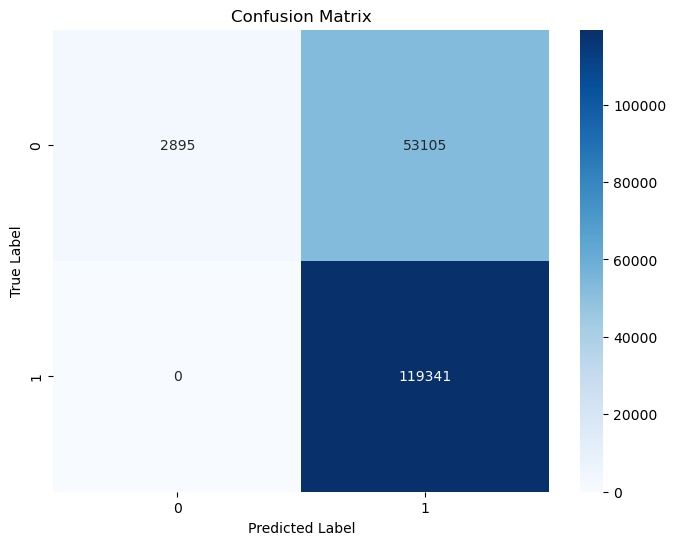

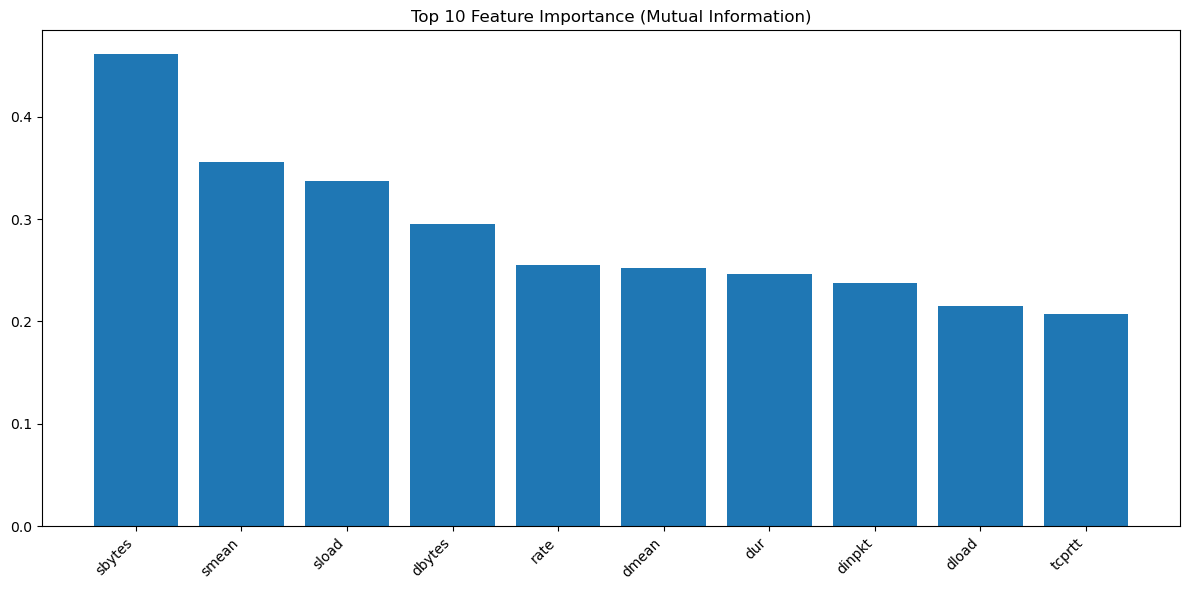

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class Preprocess:
    def __init__(self, train_file_path, test_file_path):
        self.train_df = pd.read_parquet(train_file_path)
        self.test_df = pd.read_parquet(test_file_path)
        self.lb_ub = {}

    def standardization(self, dataframe, col_name):
        mean_val = dataframe[col_name].mean()
        std_val = dataframe[col_name].std()
        dataframe[col_name] = ((dataframe[col_name] - mean_val) / std_val)

    def remove_outlier(self, data_frame, column_name, isTest=False, verbose=0):
        if isTest:
            data_frame.loc[data_frame[column_name] > self.lb_ub[column_name][1], column_name] = self.lb_ub[column_name][1]
            data_frame.loc[data_frame[column_name] < self.lb_ub[column_name][0], column_name] = self.lb_ub[column_name][0]
            return
        
        q1 = data_frame[column_name].quantile(0.25)
        q3 = data_frame[column_name].quantile(0.75)
        iqr = q3 - q1
        lb = q1 - 3 * iqr
        ub = q3 + 3 * iqr
        
        data_frame.loc[data_frame[column_name] > ub, column_name] = ub
        data_frame.loc[data_frame[column_name] < lb, column_name] = lb
        self.lb_ub[column_name] = (lb, ub)

    def get_correlated_features(self, correlation_matrix, threshold=0.8):
        num_features = correlation_matrix.shape[0]
        correlated_features = set()

        for i in range(num_features):
            for j in range(i + 1, num_features):
                if correlation_matrix[i, j] >= threshold:
                    correlated_features.add((i, j))

        return correlated_features

    def train_set_preprocess(self):
        # Handle outliers in duration
        self.remove_outlier(self.train_df, 'dur')
        
        # Max value clipping for specific columns
        self.cols_muls = {'spkts': 1.2, 'sloss': 1.2, 'dloss': 1.2}
        self.cols_maxvals = {}
        train_normal_df = self.train_df[self.train_df['label'] == 0]
        for col, multiplier in self.cols_muls.items():
            self.cols_maxvals[col] = train_normal_df[col].max()
            self.train_df.loc[self.train_df[col] > self.cols_maxvals[col], col] = (self.cols_maxvals[col] * multiplier)

        # Clip binary features to 1
        self.columns_to_limit = ['is_ftp_login', 'ct_ftp_cmd']
        for col in self.columns_to_limit:
            self.train_df.loc[self.train_df[col] > 1, col] = 1
            
        # Drop unnecessary columns
        self.columns_to_drop = ['swin', 'stcpb', 'dtcpb', 'dwin', 'attack_cat']
        self.train_df = self.train_df.drop(columns=self.columns_to_drop, axis=1)
        
        # Handle protocol categories
        col = 'proto'
        valid_protos = ['tcp', 'udp', 'arp', 'ospf', 'igmp', 'icmp', 'rtp']
        self.train_df[col] = self.train_df[col].apply(lambda x: x if x in valid_protos else 'm')
        
        valid_protos = ['igmp', 'icmp', 'rtp']
        self.train_df[col] = self.train_df[col].apply(lambda x: x if x not in valid_protos else 'n')
        
        self.train_df = pd.get_dummies(self.train_df, columns=[col], prefix='proto', drop_first=False)

        # Encode categorical variables
        self.label_encoder = LabelEncoder()
        for col in ['service', 'state']:
            if col == 'state':
                temp = ['RST', 'ECO', 'PAR', 'URN', 'no']
                self.train_df[col] = self.train_df[col].apply(lambda x: x if x not in temp else 'm')
            self.train_df[col] = self.label_encoder.fit_transform(self.train_df[col])
        
        # Convert boolean to integer
        self.train_df = self.train_df.replace({True: 0, False: 1})
        
        # Split features and target
        self.X_train = self.train_df.drop('label', axis=1)
        self.y_train = self.train_df['label']
        
        # Remove constant features
        var_thres = VarianceThreshold(threshold=0)
        var_thres.fit(self.X_train)
        self.constant_cols = self.X_train.columns[[not col for col in var_thres.get_support()]]
        self.X_train = self.X_train.drop(self.constant_cols, axis=1)
        
        # Remove highly correlated features
        correlation_matrix = np.corrcoef(self.X_train, rowvar=False)
        self.correlated_features = [self.X_train.columns[x[0]] for x in self.get_correlated_features(correlation_matrix, 0.95)]
        self.X_train = self.X_train.drop(self.correlated_features, axis=1)
        
        # Standardize numerical features
        for col in self.X_train.columns:
            self.standardization(self.X_train, col)

    def test_set_preprocess(self):
        # Apply same preprocessing steps to test set
        self.remove_outlier(self.test_df, 'dur', True)
        
        for col, multiplier in self.cols_muls.items():
            self.test_df.loc[self.test_df[col] > self.cols_maxvals[col], col] = (self.cols_maxvals[col] * multiplier)

        for col in self.columns_to_limit:
            self.test_df.loc[self.test_df[col] > 1, col] = 1
            
        self.test_df = self.test_df.drop(columns=self.columns_to_drop, axis=1)
        
        col = 'proto'
        valid_protos = ['tcp', 'udp', 'arp', 'ospf', 'igmp', 'icmp', 'rtp']
        self.test_df[col] = self.test_df[col].apply(lambda x: x if x in valid_protos else 'm')
        valid_protos = ['igmp', 'icmp', 'rtp']
        self.test_df[col] = self.test_df[col].apply(lambda x: x if x not in valid_protos else 'n')
        
        self.test_df = pd.get_dummies(self.test_df, columns=[col], prefix='proto', drop_first=False)

        for col in ['service', 'state']:
            if col == 'state':
                self.test_df[col] = self.test_df[col].apply(lambda x: x if x not in ['RST', 'ECO', 'PAR', 'URN', 'no'] else 'm')
            self.test_df[col] = self.label_encoder.fit_transform(self.test_df[col])
        
        self.test_df = self.test_df.replace({True: 0, False: 1})
        
        self.X_test = self.test_df.drop('label', axis=1)
        self.y_test = self.test_df['label']
        
        self.X_test = self.X_test.drop(self.constant_cols, axis=1)
        self.X_test = self.X_test.drop(self.correlated_features, axis=1)
        
        for col in self.X_test.columns:
            self.standardization(self.X_test, col)

# File paths
train_file_path = '../UNSW_NB15_testing-set.parquet'
test_file_path = "../UNSW_NB15_training-set.parquet"

# Preprocess the data
preprocessor = Preprocess(train_file_path, test_file_path)
preprocessor.train_set_preprocess()
preprocessor.test_set_preprocess()

X_train = preprocessor.X_train
y_train = preprocessor.y_train
X_test = preprocessor.X_test
y_test = preprocessor.y_test

# Display features used after preprocessing
print("Number of features used:", len(X_train.columns))
print("\nFeatures used:")
print(X_train.columns.tolist())

# Train Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = nb_classifier.predict(X_test)

# Calculate feature importance using mutual information
feature_importance = mutual_info_classif(X_train, y_train)
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'].head(10), importance_df['Importance'].head(10))
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Feature Importance (Mutual Information)')
plt.tight_layout()
plt.show()